In [637]:
# first we need a bit of import boilerplate
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

output_dir = os.path.expanduser("~/ecephys/data")
resources_dir = Path.cwd().parent / 'resources'
DOWNLOAD_LFP = False

def pprint_mae(model_name, pred):
    print('{} MAE: {:.3f} x 10e-4'.format(model_name,mean_absolute_error(y,pred)*10**4))

def get_model(path):
    with open(path, "rb") as f:
        return pkl.load(f)


In [638]:
# Example cache directory path, it determines where downloaded data will be stored
manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
session_id = 756029989 # for example
session = cache.get_session_data(session_id)

/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/mxwaldo/.pyenv/versions/copGP/lib/python3.11/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [639]:
session.get_screen_gaze_data()


,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.20620,0.072246,0.008627,3.192181,0.863288,11.996034,3.294251
3.22948,0.072116,0.008734,3.103325,0.916339,11.669031,3.496204
3.23714,0.072292,0.008807,3.116553,0.919020,11.717276,3.506406
3.27028,0.072347,0.008060,3.107700,1.061316,11.677819,4.047634
3.30396,0.072026,0.008814,3.285226,0.929605,12.331983,3.546691
...,...,...,...,...,...,...
9939.71240,NaN,NaN,NaN,NaN,NaN,NaN
9939.74576,NaN,NaN,NaN,NaN,NaN,NaN
9939.77918,NaN,NaN,NaN,NaN,NaN,NaN


In [640]:
with open('../data/processed/traj_and_pupil_data.pkl','rb') as f:
    traj_pupil_data = pkl.load(f)

traj_pupil_data

{'trajectories': array([array([[ 1.36787517,  0.87587769,  0.69618301, ..., -0.40621823,
                -0.76293471, -0.75680705],
               [ 1.19182001,  0.16587495, -0.84340428, ...,  0.3107325 ,
                -0.06493757, -0.18065655],
               [ 0.49989296,  0.86093951,  1.1917584 , ..., -0.26538589,
                -0.19455004, -0.13975237],
               ...,
               [ 0.18588842,  0.25407247,  0.32199621, ...,  0.10042668,
                 0.10323803,  0.106031  ],
               [ 0.32585712,  0.36613495,  0.39597275, ...,  0.11391229,
                 0.12175979,  0.12694887],
               [-0.65007558, -0.75955466, -0.83792719, ..., -0.34844545,
                -0.36988291, -0.36018696]])                             ,
        array([[ 1.40400812,  1.09042033,  1.63253316, ...,  0.00944795,
                -0.3561726 , -0.63975347],
               [ 0.28933225, -0.66707858, -0.84674546, ...,  0.13776242,
                -0.04609017,  0.01895273],
     

In [641]:
xgb = get_model("../models/regression_models/initial_cv/xgb.pkl")
ridge = get_model("../models/regression_models/initial_cv/ridge.pkl")
rf = get_model("../models/regression_models/initial_cv/rf.pkl")

lstm = get_model("../models/nn_models/lstm.pkl")
lstm_rf = get_model("../models/nn_models/rf_lstm.pkl")
lstm_xgb = get_model("../models/nn_models/xgb_lstm.pkl")
lstm_ridge = get_model("../models/nn_models/ridge_lstm.pkl")

In [667]:
n=80

y = np.concatenate(np.stack(traj_pupil_data["pupil area"])[n:,:100])
X = np.concatenate(np.stack(traj_pupil_data["trajectories"])[n:,:,:100],axis=1).T


In [668]:
xgb_pred = xgb.predict(X)
ridge_pred = ridge.predict(X)
rf_pred = rf.predict(X)

xgb_pred.shape

(2000,)

In [669]:
pprint_mae('XGB',xgb_pred)
pprint_mae('RF', rf_pred)
pprint_mae('Ridge', ridge_pred)

XGB MAE: 1.534 x 10e-4
RF MAE: 1.742 x 10e-4
Ridge MAE: 1.371 x 10e-4


In [670]:
import torch

lstm_pred = lstm(torch.Tensor(X)).reshape(len(y)).detach().numpy()
lstm_xgb_pred = lstm_xgb(torch.Tensor(xgb_pred).reshape(len(y),1)).reshape(len(y)).detach().numpy()
lstm_rf_pred = lstm_xgb(torch.Tensor(rf_pred).reshape(len(y),1)).reshape(len(y)).detach().numpy()
lstm_ridge_pred = lstm_xgb(torch.Tensor(ridge_pred).reshape(len(y),1)).reshape(len(y)).detach().numpy()

lstm_xgb_pred.shape

(2000,)

In [671]:
pprint_mae('LSTM',lstm_pred)
pprint_mae('XGB into LSTM',lstm_xgb_pred)
pprint_mae('RF into LSTM', lstm_rf_pred)
pprint_mae('Ridge into LSTM', lstm_ridge_pred)

LSTM MAE: 4.185 x 10e-4
XGB into LSTM MAE: 4.268 x 10e-4
RF into LSTM MAE: 4.272 x 10e-4
Ridge into LSTM MAE: 4.277 x 10e-4


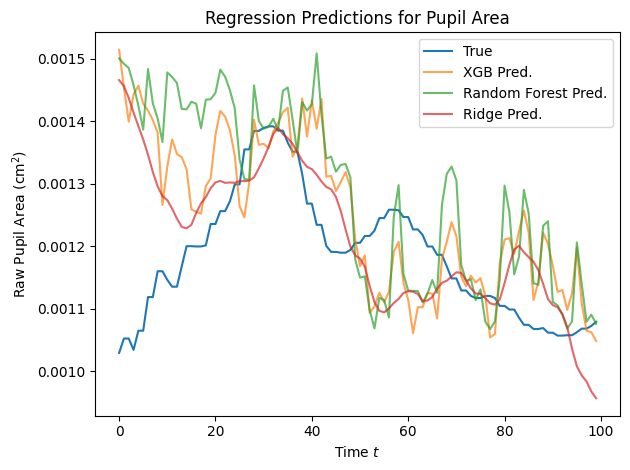

In [672]:
plt.plot(y[-100:],label='True')
plt.plot(xgb_pred[-100:],alpha=0.7,label='XGB Pred.')
plt.plot(rf_pred[-100:],alpha=0.7,label='Random Forest Pred.')
plt.plot(ridge_pred[-100:],alpha=0.7,label='Ridge Pred.')
plt.legend()
plt.ylabel('Raw Pupil Area (cm$^2$)')
plt.xlabel('Time $t$')
plt.title('Regression Predictions for Pupil Area')
plt.tight_layout()
plt.savefig('reg_pred.png')

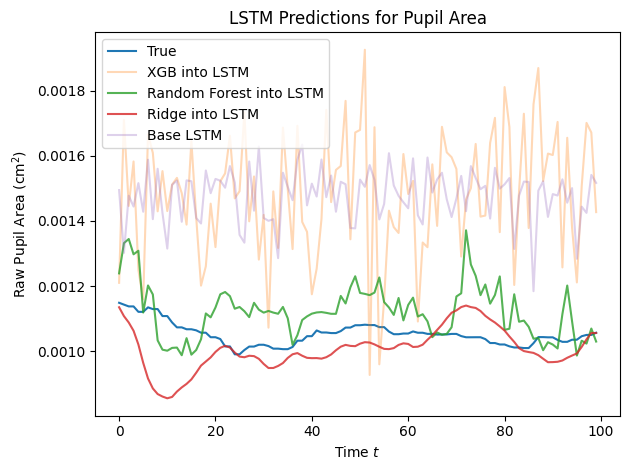

In [673]:
n = 19

plt.plot(y[-100*n:-100*(n-1)],label='True')
plt.plot(lstm_xgb_pred[-100*n:-100*(n-1)],alpha=0.3,label='XGB into LSTM')
plt.plot(rf_pred[-100*n:-100*(n-1)],alpha=0.8,label='Random Forest into LSTM')
plt.plot(ridge_pred[-100*n:-100*(n-1)],alpha=.8,label='Ridge into LSTM')
plt.plot(lstm_pred[-100*n:-100*(n-1)],alpha=0.3,label='Base LSTM')
plt.legend()
plt.ylabel('Raw Pupil Area (cm$^2$)')
plt.xlabel('Time $t$')
plt.title('LSTM Predictions for Pupil Area')
plt.tight_layout()
plt.savefig('LSTM_pred.png')

In [674]:
stacked_pred = np.stack(
    (
        np.arange(lstm_pred.shape[0]),
        lstm_pred,
        lstm_rf_pred,
        lstm_xgb_pred,
        lstm_ridge_pred,
        rf_pred,
        xgb_pred,
        ridge_pred,
    ),
    axis=1
)

with open('../models/ensemble.pkl','rb') as f:
    ens_model = pkl.load(f)

In [675]:
final_pred = ens_model.predict(stacked_pred[:,:4])

mean_absolute_error(y,final_pred)

0.0003346676434489081

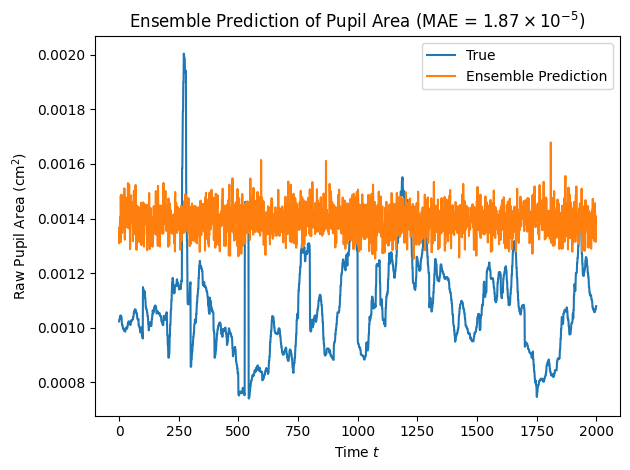

In [681]:
plt.plot(y,label='True')
plt.plot(final_pred,label='Ensemble Prediction')
plt.title('Ensemble Prediction of Pupil Area (MAE = $1.87\\times 10^{-5}$)')
plt.legend()
plt.ylabel('Raw Pupil Area (cm$^2$)')
plt.xlabel('Time $t$')
plt.tight_layout()
plt.savefig('ens_pred.png')

In [677]:
ens_model.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=6, n_estimators=50)>

In [678]:
ens_model.feature_importances_

array([0.28114642, 0.2581478 , 0.23106921, 0.22963657])

In [679]:
from numpy import genfromtxt

nns = ['lstm','xgb_lstm','rf_lstm','ridge_lstm']
tr_losses = [genfromtxt(f'{nn}_train_loss.csv',delimiter=',') for nn in nns]
val_losses = [genfromtxt(f'{nn}_val_loss.csv',delimiter=',') for nn in nns]

for model,(tr_loss,val_loss) in zip(nns,zip(tr_losses,val_losses)):
    print(f'Model:\t {model}    \t||     Final Train Loss:\t {tr_loss[-1]*10**4:.5f} x 10e-4\t||     Final Val Loss:\t {val_loss[-1]*10**4:.5f} x 10e-4')

Model:	 lstm    	||     Final Train Loss:	 4.20387 x 10e-4	||     Final Val Loss:	 4.22986 x 10e-4
Model:	 xgb_lstm    	||     Final Train Loss:	 4.34386 x 10e-4	||     Final Val Loss:	 4.29626 x 10e-4
Model:	 rf_lstm    	||     Final Train Loss:	 4.34389 x 10e-4	||     Final Val Loss:	 4.29665 x 10e-4
Model:	 ridge_lstm    	||     Final Train Loss:	 4.34394 x 10e-4	||     Final Val Loss:	 4.29702 x 10e-4


ValueError: x and y must have same first dimension, but have shapes (100,) and (500,)

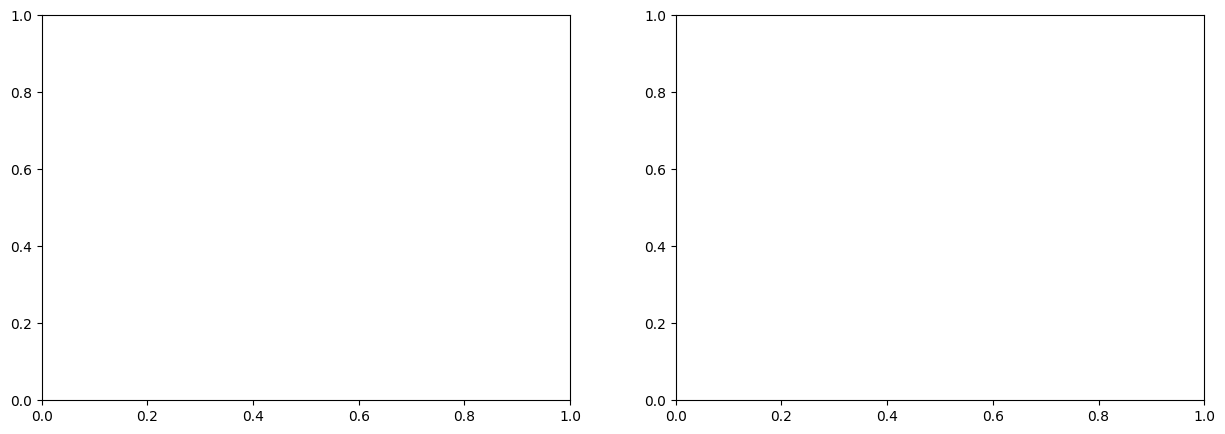

In [680]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
labels = ['base LSTM','XGB into LSTM','Random Forest into LSTM','Ridge into LSTM']

for n,(tr_loss,val_loss) in enumerate(zip(tr_losses[:1],val_losses[:1])):
    ax1.plot(np.arange(100),tr_loss)
    ax2.plot(np.arange(100),val_loss,label=labels[n])
ax1.set_ylim([0,0.015])
ax2.set_ylim([0,0.015])
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('L1 Loss')
ax2.legend(prop={'size':12})
ax1.set_title('Training Loss',fontsize=16)
ax2.set_title('Validation Loss',fontsize=16)
plt.tight_layout()
plt.savefig('pipe_loss_curves.png')

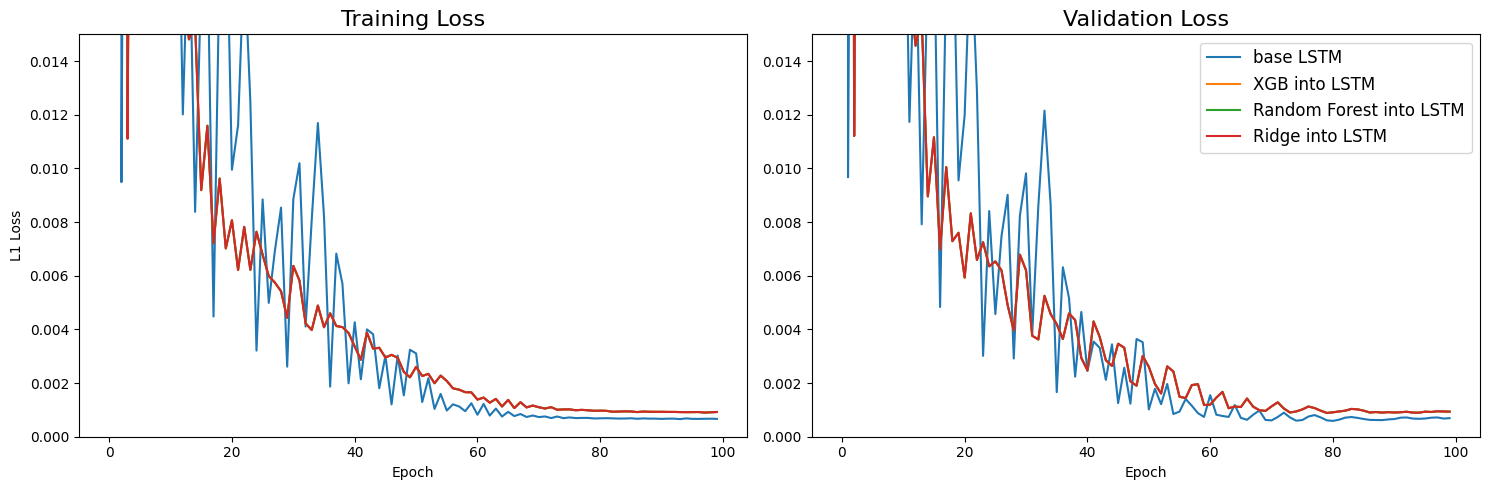

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
labels = ['base LSTM','XGB into LSTM','Random Forest into LSTM','Ridge into LSTM']

for n,(tr_loss,val_loss) in enumerate(zip(tr_losses,val_losses)):
    ax1.plot(np.arange(100),tr_loss)
    ax2.plot(np.arange(100),val_loss,label=labels[n])
ax1.set_ylim([0,0.015])
ax2.set_ylim([0,0.015])
ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('L1 Loss')
ax2.legend(prop={'size':12})
ax1.set_title('Training Loss',fontsize=16)
ax2.set_title('Validation Loss',fontsize=16)
plt.tight_layout()
plt.savefig('pipe_loss_curves.png')